In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from scipy.stats import multivariate_normal

pd.set_option('display.max_rows', 10)
%matplotlib inline

### Load data

Text(0,0.5,'waiting')

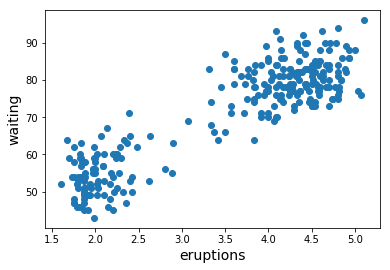

In [2]:
data = pd.read_csv('data/data.csv')
plt.scatter(data.iloc[:, 0], data.iloc[:, 1])
plt.xlabel(data.columns[0], fontsize=14)
plt.ylabel(data.columns[1], fontsize=14)

### Scale data

In [3]:
scaler = MinMaxScaler()
scaler.fit(data)
data_scaled = pd.DataFrame(scaler.transform(data), columns=data.columns)
display(data_scaled)

,eruptions,waiting
0,0.571429,0.679245
1,0.057143,0.207547
2,0.495143,0.584906
3,0.195143,0.358491
4,0.838000,0.792453
...,...,...
267,0.719143,0.716981
268,0.157143,0.056604
269,0.804857,0.886792
270,0.062000,0.056604


### Gaussian Mixture Model - Expection Maximization Algorithm

In [4]:
class GMM_EM:
    def __init__(self, K, data):
        self.K = K
        self.data = data
        self.num_data, self.num_features = self.data.shape
        
        
    def __get_init_params(self):
        mu = np.random.rand(self.K, self.num_features)
        cov = np.array([np.diag([0.1, 0.1])] * self.K)
        pi = np.array([1.0 / self.K] * self.K)
        print("Parameters initialized:","mu:", mu, "cov:", cov, "pi:", pi, sep="\n")
        return mu, cov, pi

    
    def __get_expectation(self, mu, cov, pi):
        # Calculate probabilities for all samples to each model
        prob = np.zeros((self.num_data, self.K))
        for k in range(self.K):
            prob[:, k] = multivariate_normal.pdf(self.data, mean=mu[k], cov=cov[k])
        
        # Calculate responsibility for each model to every sample
        resp = np.zeros((self.num_data, self.K))
        for k in range(self.K):
            resp[:, k] = pi[k] * prob[:, k]
        for i in range(self.num_data):
            summ = np.sum(resp[i, :])
            if summ != 0:
                resp[i, :] /= summ
        
        return resp
        
        
    def __maximize(self, resp):
        mu = np.zeros((self.K, self.num_features))
        cov = []
        pi = np.zeros(self.K)

        # Update parameters for every model 
        for k in range(self.K):
            # sum of responses of all samples for kth model
            sum_resp = np.sum(resp[:, k])
    
            # mean  
            for f in range(self.num_features):
                mu[k, f] = np.sum(np.multiply(resp[:, k], self.data[:, f])) / sum_resp
            
            # cov (spherical)
            cov_k = np.zeros(self.num_features)
            for i in range(self.num_features):
                cov_k[i] = resp[i, k] * np.sum(np.square((self.data[i] - mu[k]))) / sum_resp
            cov.append(np.diag([np.average(cov_k), np.average(cov_k)]))
            
            # pi
            pi[k] = sum_resp / self.num_data
            
        return mu, np.array(cov), pi
        
    
    def run(self, iterations):
        mu, cov, pi = self.__get_init_params()
        mus = [[[] for _ in range(self.num_features)] for __ in range(self.K)]
        for i in range(self.K):
                for j in range(self.num_features):
                    mus[i][j].append(mu[i][j])
                    
        for _ in range(iterations):
            resp = self.__get_expectation(mu, cov, pi)
            mu, cov, pi = self.__maximize(resp)
            for i in range(self.K):
                for j in range(self.num_features):
                    mus[i][j].append(mu[i][j])
                
        return mus

Parameters initialized:
mu:
[[0.46195045 0.16864724]
 [0.0654861  0.99648832]]
cov:
[[[0.1 0. ]
  [0.  0.1]]

 [[0.1 0. ]
  [0.  0.1]]]
pi:
[0.5 0.5]


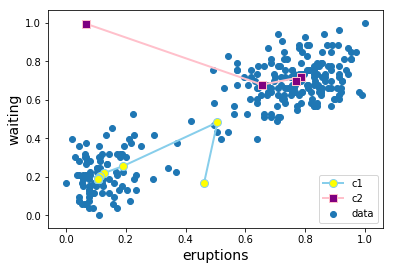

In [5]:
model = GMM_EM(2, data_scaled.values)
mus = model.run(50)

mus1 = pd.DataFrame({data.columns[0]: mus[0][0], data.columns[1]: mus[0][1]})
mus2 = pd.DataFrame({data.columns[0]: mus[1][0], data.columns[1]: mus[1][1]})

plt.scatter(data_scaled.iloc[:, 0], data_scaled.iloc[:, 1], label="data", alpha=1)
plt.xlabel(data.columns[0], fontsize=14)
plt.ylabel(data.columns[1], fontsize=14)
plt.plot(data.columns[0], data.columns[1], data=mus1, label='c1', marker='o', markerfacecolor='yellow', markersize=8, color='skyblue', linewidth=2)
plt.plot(data.columns[0], data.columns[1], data=mus2, label='c2', marker='s', markerfacecolor='purple', markersize=8, color='pink', linewidth=2)
plt.legend()